tREINAR MODELO COPERNICUS

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input

In [28]:
df = pd.read_csv('oceanographic and meteorological dataset.csv')

In [29]:
def add_direction_features(df, col):
    df[f'{col}_sin'] = np.sin(np.deg2rad(df[col]))
    df[f'{col}_cos'] = np.cos(np.deg2rad(df[col]))
    return df

In [30]:
df = add_direction_features(df, 'mwd_cop')

In [31]:
df = df.dropna()
df.describe()

,u10_era5,v10_era5,mwd_era5,mwp_era5,swh_era5,pp1d_era5,uo_cop,vo_cop,swh_cop,mwp_cop,mwd_cop,peak_period_cop,mwd_cop_sin,mwd_cop_cos
count,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000
mean,2.192449,-0.730460,255.950462,8.431290,2.266529,10.372565,-0.009596,-0.019624,2.396094,6.664016,260.916772,10.912761,-0.450800,0.459881
std,5.079766,5.736857,101.366399,1.510548,1.365365,2.244493,0.105901,0.107473,1.456047,1.374168,99.155991,2.368424,0.589320,0.488117
min,-9.547089,-17.162354,0.018279,5.445876,0.706664,4.671730,-0.449219,-0.603516,0.620000,3.730000,0.030000,4.760000,-1.000000,-0.999941
25%,-1.480034,-4.484627,247.180280,7.312723,1.254206,8.716774,-0.083984,-0.083984,1.310000,5.590000,255.900000,9.130000,-0.924246,0.172230
50%,1.905762,-1.490417,292.653320,8.212036,1.747956,10.147072,-0.011719,-0.020508,1.860000,6.530000,294.380000,10.680000,-0.667248,0.563454
75%,5.677345,3.126087,322.369933,9.229351,2.921544,11.816139,0.059570,0.044922,3.110000,7.620000,326.745000,12.432500,-0.197144,0.891224
max,20.644135,16.901077,359.915250,14.486108,8.796758,19.196136,0.535156,0.473633,9.290000,11.420000,359.920000,20.010000,1.000000,1.000000


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2184 entries, 0 to 6549
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             2184 non-null   object 
 1   u10_era5         2184 non-null   float64
 2   v10_era5         2184 non-null   float64
 3   mwd_era5         2184 non-null   float64
 4   mwp_era5         2184 non-null   float64
 5   swh_era5         2184 non-null   float64
 6   pp1d_era5        2184 non-null   float64
 7   uo_cop           2184 non-null   float64
 8   vo_cop           2184 non-null   float64
 9   swh_cop          2184 non-null   float64
 10  mwp_cop          2184 non-null   float64
 11  mwd_cop          2184 non-null   float64
 12  peak_period_cop  2184 non-null   float64
 13  mwd_cop_sin      2184 non-null   float64
 14  mwd_cop_cos      2184 non-null   float64
dtypes: float64(14), object(1)
memory usage: 273.0+ KB


In [33]:
colunas_para_remover = ['swh_era5', 'mwp_era5', 'pp1d_era5', 'time','mwd_era5','u10_era5','v10_era5' ]

df = df.drop(columns=colunas_para_remover, errors='ignore')

df.describe()

,uo_cop,vo_cop,swh_cop,mwp_cop,mwd_cop,peak_period_cop,mwd_cop_sin,mwd_cop_cos
count,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000
mean,-0.009596,-0.019624,2.396094,6.664016,260.916772,10.912761,-0.450800,0.459881
std,0.105901,0.107473,1.456047,1.374168,99.155991,2.368424,0.589320,0.488117
min,-0.449219,-0.603516,0.620000,3.730000,0.030000,4.760000,-1.000000,-0.999941
25%,-0.083984,-0.083984,1.310000,5.590000,255.900000,9.130000,-0.924246,0.172230
50%,-0.011719,-0.020508,1.860000,6.530000,294.380000,10.680000,-0.667248,0.563454
75%,0.059570,0.044922,3.110000,7.620000,326.745000,12.432500,-0.197144,0.891224
max,0.535156,0.473633,9.290000,11.420000,359.920000,20.010000,1.000000,1.000000


Criar o modelo

In [34]:
def create_supervised_dataset(df, features, target, lookback, horizon):
    X, y = [], []

    data = df[features + [target]].values

    for i in range(lookback, len(df) - horizon):
        X.append(data[i - lookback:i, :-1])
        y.append(data[i + horizon, -1])

    return np.array(X), np.array(y)

In [35]:
def temporal_train_val_test_split(X, y, train=0.7, val=0.1):
    n = len(X)
    n_train = int(n * train)
    n_val = int(n * (train + val))

    X_train = X[:n_train]
    y_train = y[:n_train]

    X_val = X[n_train:n_val]
    y_val = y[n_train:n_val]

    X_test = X[n_val:]
    y_test = y[n_val:]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [36]:
def scale_data(X_train, X_test):
    n_samples, timesteps, n_features = X_train.shape

    scaler = StandardScaler()
    X_train_2d = X_train.reshape(-1, n_features)
    X_test_2d  = X_test.reshape(-1, n_features)

    X_train_scaled = scaler.fit_transform(X_train_2d)
    X_test_scaled  = scaler.transform(X_test_2d)

    X_train_scaled = X_train_scaled.reshape(n_samples, timesteps, n_features)
    X_test_scaled  = X_test_scaled.reshape(X_test.shape[0], timesteps, n_features)

    return X_train_scaled, X_test_scaled, scaler

In [37]:
def build_cnn_model(input_shape):
    model = Sequential([
        # Forma moderna de definir a entrada
        Input(shape=input_shape), 
        
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),

        
        Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [38]:
HORIZONS = [1, 2, 4, 8]
LOOKBACK = 48
TARGETS = ['swh_cop', 'mwp_cop', 'peak_period_cop']
FEATURES = ['uo_cop', 'vo_cop', 'swh_cop', 'mwd_cop_sin','mwd_cop_cos', 'mwp_cop', 'peak_period_cop']
results = []

for target in TARGETS:
    for h in HORIZONS:

        print(f'\nTreinar target={target} | horizonte={h}h')

        # criar dataset
        X, y = create_supervised_dataset(
            df,
            FEATURES,
            target,
            LOOKBACK,
            h
        )

        X_train, X_val, X_test, y_train, y_val, y_test = temporal_train_val_test_split(X, y)
        X_train, X_test, scaler = scale_data(X_train, X_test)

        model = build_cnn_model(X_train.shape[1:])

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val,y_val),
            epochs=20,
            batch_size=32,
            verbose=2,
            
        )

        y_pred = model.predict(X_test).ravel()

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae  = mean_absolute_error(y_test, y_pred)
        r2   = r2_score(y_test, y_pred)

        print(f'RMSE = {rmse:.3f} | MAE = {mae:.3f} | R2 = {r2:.3f}')

        results.append({
            'target': target,
            'horizon': h,
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        })  


Treinar target=swh_cop | horizonte=1h
Epoch 1/20
47/47 - 5s - 97ms/step - loss: 2.3107 - mae: 1.1267 - val_loss: 31.1778 - val_mae: 5.4974
Epoch 2/20
47/47 - 0s - 11ms/step - loss: 0.9682 - mae: 0.7334 - val_loss: 12.1285 - val_mae: 3.3748
Epoch 3/20
47/47 - 0s - 9ms/step - loss: 0.7243 - mae: 0.6203 - val_loss: 11.5513 - val_mae: 3.1504
Epoch 4/20
47/47 - 0s - 8ms/step - loss: 0.5698 - mae: 0.5408 - val_loss: 22.5537 - val_mae: 4.4683
Epoch 5/20
47/47 - 0s - 7ms/step - loss: 0.4760 - mae: 0.4930 - val_loss: 21.9134 - val_mae: 4.3334
Epoch 6/20
47/47 - 0s - 8ms/step - loss: 0.4180 - mae: 0.4662 - val_loss: 24.2976 - val_mae: 4.5115
Epoch 7/20
47/47 - 1s - 12ms/step - loss: 0.3842 - mae: 0.4468 - val_loss: 28.2524 - val_mae: 4.8318
Epoch 8/20
47/47 - 1s - 11ms/step - loss: 0.3245 - mae: 0.4159 - val_loss: 16.8959 - val_mae: 3.5926
Epoch 9/20
47/47 - 1s - 13ms/step - loss: 0.3318 - mae: 0.4096 - val_loss: 31.8348 - val_mae: 5.1177
Epoch 10/20
47/47 - 1s - 12ms/step - loss: 0.3105 - mae:

In [39]:
results_df = pd.DataFrame(results)

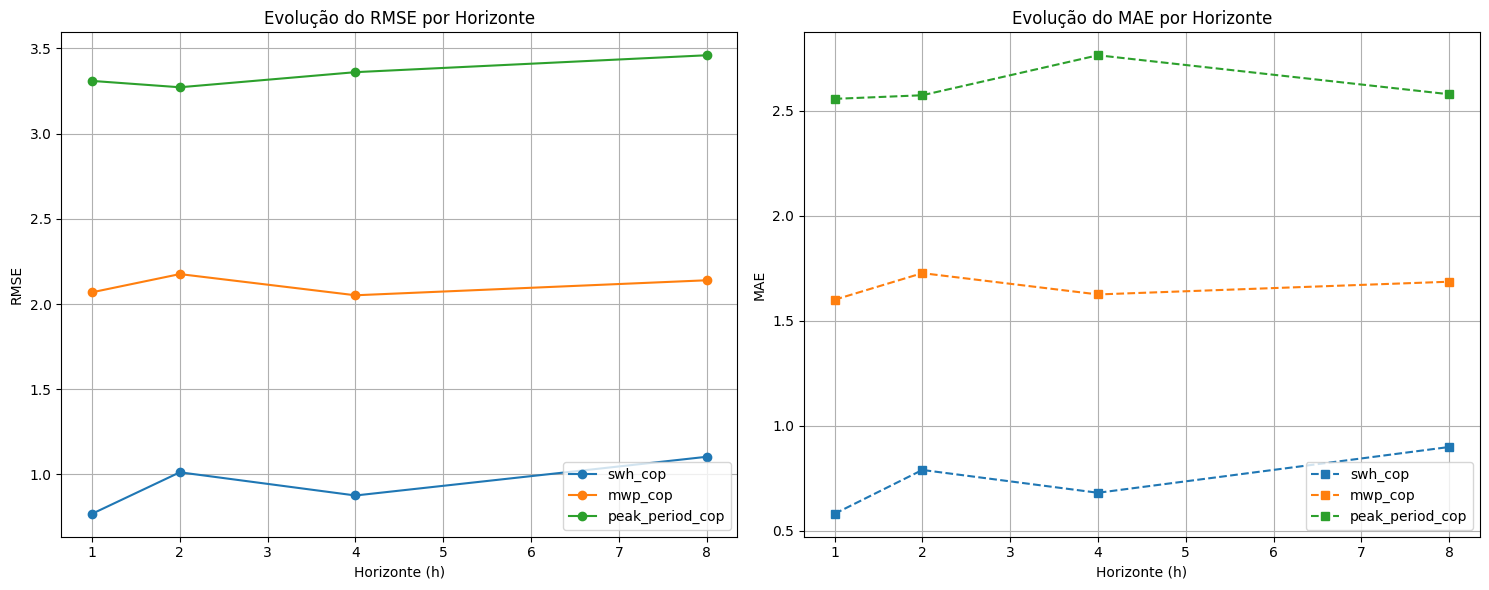

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for target in TARGETS:
    subset = results_df[results_df['target'] == target]
    
    # Gráfico 1: RMSE
    ax1.plot(subset['horizon'], subset['rmse'], marker='o', label=target)
    
    # Gráfico 2: MAE
    ax2.plot(subset['horizon'], subset['mae'], marker='s', linestyle='--', label=target)

# Ajustes do gráfico de RMSE
ax1.set_title('Evolução do RMSE por Horizonte')
ax1.set_xlabel('Horizonte (h)')
ax1.set_ylabel('RMSE')
ax1.legend()
ax1.grid(True)

# Ajustes do gráfico de MAE
ax2.set_title('Evolução do MAE por Horizonte')
ax2.set_xlabel('Horizonte (h)')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [41]:
print("\n--- RESUMO DOS RESULTADOS (RMSE) ---")
pivot_rmse = results_df.pivot(index='horizon', columns='target', values='rmse')
display(pivot_rmse.round(4))

print("\n--- RESUMO DOS RESULTADOS (MAE) ---")
pivot_mae = results_df.pivot(index='horizon', columns='target', values='mae')
display(pivot_mae.round(4))


--- RESUMO DOS RESULTADOS (RMSE) ---


target,mwp_cop,peak_period_cop,swh_cop
horizon,,,
1,2.0688,3.3091,0.7692
2,2.1756,3.2717,1.0128
4,2.0513,3.3604,0.8766
8,2.1394,3.4595,1.1038



--- RESUMO DOS RESULTADOS (MAE) ---


target,mwp_cop,peak_period_cop,swh_cop
horizon,,,
1,1.6010,2.5577,0.5816
2,1.7278,2.5749,0.7905
4,1.6263,2.7653,0.6818
8,1.6869,2.5795,0.8998


MODELO SEM VARIAVEIS DE CORRENTE

In [42]:
HORIZONS = [1, 2, 4, 8]
LOOKBACK = 48
TARGETS = ['swh_cop', 'mwp_cop', 'peak_period_cop']
FEATURES = ['swh_cop', 'mwd_cop_sin','mwd_cop_cos', 'mwp_cop', 'peak_period_cop']
results = []

for target in TARGETS:
    for h in HORIZONS:

        print(f'\nTreinar target={target} | horizonte={h}h')

        # criar dataset
        X, y = create_supervised_dataset(
            df,
            FEATURES,
            target,
            LOOKBACK,
            h
        )

        X_train, X_val, X_test, y_train, y_val, y_test = temporal_train_val_test_split(X, y)
        X_train, X_test, scaler = scale_data(X_train, X_test)

        model = build_cnn_model(X_train.shape[1:])

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val,y_val),
            epochs=20,
            batch_size=32,
            verbose=2,
            
        )

        y_pred = model.predict(X_test).ravel()

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae  = mean_absolute_error(y_test, y_pred)
        r2   = r2_score(y_test, y_pred)

        print(f'RMSE = {rmse:.3f} | MAE = {mae:.3f} | R2 = {r2:.3f}')

        results.append({
            'target': target,
            'horizon': h,
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        })  


Treinar target=swh_cop | horizonte=1h
Epoch 1/20
47/47 - 8s - 163ms/step - loss: 3.0152 - mae: 1.2850 - val_loss: 115.4303 - val_mae: 10.6255
Epoch 2/20
47/47 - 1s - 20ms/step - loss: 1.2656 - mae: 0.8257 - val_loss: 44.0067 - val_mae: 6.5075
Epoch 3/20
47/47 - 1s - 29ms/step - loss: 0.9684 - mae: 0.7069 - val_loss: 68.8321 - val_mae: 7.9877
Epoch 4/20
47/47 - 1s - 20ms/step - loss: 0.7489 - mae: 0.6219 - val_loss: 61.5766 - val_mae: 7.4558
Epoch 5/20
47/47 - 1s - 20ms/step - loss: 0.6007 - mae: 0.5642 - val_loss: 56.7031 - val_mae: 7.1762
Epoch 6/20
47/47 - 1s - 20ms/step - loss: 0.5119 - mae: 0.5172 - val_loss: 56.2931 - val_mae: 7.1732
Epoch 7/20
47/47 - 1s - 20ms/step - loss: 0.4336 - mae: 0.4758 - val_loss: 67.7100 - val_mae: 7.8255
Epoch 8/20
47/47 - 1s - 19ms/step - loss: 0.3810 - mae: 0.4508 - val_loss: 41.0914 - val_mae: 6.1307
Epoch 9/20
47/47 - 1s - 19ms/step - loss: 0.3279 - mae: 0.4205 - val_loss: 55.2127 - val_mae: 7.1148
Epoch 10/20
47/47 - 1s - 19ms/step - loss: 0.3453

In [43]:
results_df['Versão'] = 'Completo'
results_df_corr = pd.DataFrame(results)
results_df_corr['Versão'] = 'Sem corrente'

# 2. Concatenar os dois DataFrames
df_final = pd.concat([results_df, results_df_corr])

# 3. Criar a Pivot Table com Multi-Index nas colunas
# O index será o horizonte, e as colunas serão divididas por Target e depois por Versão
pivot_comparativa = df_final.pivot_table(
    index='horizon', 
    columns=['target', 'Versão'], 
    values='rmse'
)

print("\n--- COMPARAÇÃO DE RESULTADOS (RMSE): COM VS SEM VARIÁVEIS EXÓGENAS ---")
display(pivot_comparativa.round(4))

# --- CORREÇÃO PARA O MAE ---
print("\n--- COMPARAÇÃO DE RESULTADOS (MAE): COM VS SEM VARIÁVEIS EXÓGENAS ---")

# Usamos o df_final (que contém 'Completo' e 'Sem Vento/Corr.')
pivot_mae_comparativa = df_final.pivot_table(
    index='horizon', 
    columns=['target', 'Versão'], 
    values='mae'
)

display(pivot_mae_comparativa.round(4))


--- COMPARAÇÃO DE RESULTADOS (RMSE): COM VS SEM VARIÁVEIS EXÓGENAS ---


target   mwp_cop              peak_period_cop               swh_cop  \
Versão  Completo Sem corrente        Completo Sem corrente Completo   
horizon                                                               
1         2.0688       1.8464          3.3091       2.5593   0.7692   
2         2.1756       1.9725          3.2717       2.7821   1.0128   
4         2.0513       2.1205          3.3604       2.7824   0.8766   
8         2.1394       2.1450          3.4595       3.1220   1.1038   

target                
Versão  Sem corrente  
horizon               
1             0.8714  
2             0.7962  
4             0.9290  
8             1.2641


--- COMPARAÇÃO DE RESULTADOS (MAE): COM VS SEM VARIÁVEIS EXÓGENAS ---


target   mwp_cop              peak_period_cop               swh_cop  \
Versão  Completo Sem corrente        Completo Sem corrente Completo   
horizon                                                               
1         1.6010       1.4193          2.5577       2.0525   0.5816   
2         1.7278       1.5448          2.5749       2.1797   0.7905   
4         1.6263       1.6791          2.7653       2.1556   0.6818   
8         1.6869       1.6669          2.5795       2.4781   0.8998   

target                
Versão  Sem corrente  
horizon               
1             0.6415  
2             0.5778  
4             0.6703  
8             0.8603

MODELO PARA VARIAVEL MWD SIN E COS

In [44]:
def build_cnn_model(input_shape, output_units=1): # Adiciona este parâmetro
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_units)) # <--- Usa a variável aqui em vez de fixar em 1 ou 2
    model.compile(optimizer='adam', loss='mse')
    return model

In [45]:
def angular_error_deg(true, pred):
    """Diferença angular mínima em graus"""
    delta = np.arctan2(np.sin(np.deg2rad(pred - true)),
                       np.cos(np.deg2rad(pred - true)))
    return np.rad2deg(delta)

In [46]:
def create_supervised_dataset(df, features, target, lookback, horizon):
    # Garante que target é uma lista para a concatenação funcionar
    if isinstance(target, str):
        target = [target]
        
    X, y = [], []
    # Agora features + target será sempre [lista] + [lista]
    data = df[features + target].values  
    
    n_features = len(features)
    n_targets = len(target)

    for i in range(len(data) - lookback - horizon + 1):
        X.append(data[i:i + lookback, :n_features])
        # Seleciona todas as colunas de target
        y.append(data[i + lookback + horizon - 1, n_features:])
        
    return np.array(X), np.array(y)

In [47]:
def circular_metrics(y_true, y_pred):
    # 1. Calcular a diferença absoluta (0-360)
    diff = np.abs(y_true - y_pred) % 360
    
    # 2. Ajustar para o caminho mais curto (se diff > 180, o erro real é 360 - diff)
    # Exemplo: Real 1°, Previsto 359° -> diff = 358. Ajustado = 360 - 358 = 2°
    shortest_diff = np.where(diff > 180, 360 - diff, diff)
    
    # 3. Calcular métricas baseadas na diferença corrigida
    rmse_circ = np.sqrt(np.mean(shortest_diff**2))
    mae_circ = np.mean(shortest_diff)
    
    return rmse_circ, mae_circ

In [48]:
TARGETS = [['mwd_cop_sin','mwd_cop_cos']]
FEATURES = ['uo_cop', 'vo_cop','swh_cop', 'mwd_cop_sin','mwd_cop_cos', 'mwp_cop', 'peak_period_cop']
results = []

results = []

for target in TARGETS:
    for h in HORIZONS:
        print(f'\nTreinar target={target} | horizonte={h}h')

        # 1. Criar dataset (A função que corrigimos antes aceita listas)
        X, y = create_supervised_dataset(df, FEATURES, target, LOOKBACK, h)

        X_train, X_val, X_test, y_train, y_val, y_test = temporal_train_val_test_split(X, y)
        X_train, X_test, scaler = scale_data(X_train, X_test)

        # n_outputs será 2 porque len(['sin', 'cos']) == 2
        n_outputs = y.shape[1] if len(y.shape) > 1 else 1
        
        model = build_cnn_model(X_train.shape[1:], output_units=n_outputs)

        # 2. Treinar
        model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                  epochs=20, batch_size=32, verbose=0)

        # 3. Previsão
        y_pred = model.predict(X_test)

        # --- AVALIAÇÃO ---
        if n_outputs == 2:
            y_test_deg = np.degrees(np.arctan2(y_test[:, 0], y_test[:, 1])) % 360
            y_pred_deg = np.degrees(np.arctan2(y_pred[:, 0], y_pred[:, 1])) % 360
            rmse, mae = circular_metrics(y_test_deg, y_pred_deg)
            r2 = r2_score(y_test_deg, y_pred_deg)
            target_name = 'mwd_cop' # Nome simplificado para a tabela final
        else:
            y_pred = y_pred.ravel() 
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae  = mean_absolute_error(y_test, y_pred)
            r2   = r2_score(y_test, y_pred)
            target_name = target[0] if isinstance(target, list) else target

        print(f'RMSE final = {rmse:.3f} | MAE = {mae:.3f}')

        # IMPORTANTE: results.append tem de estar dentro deste loop (mais à direita)
        results.append({
            'target': target_name,
            'horizon': h,
            'Versão': 'Completo', # Para bater certo com o teu DataFrame final
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        })


Treinar target=['mwd_cop_sin', 'mwd_cop_cos'] | horizonte=1h
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RMSE final = 34.600 | MAE = 22.055

Treinar target=['mwd_cop_sin', 'mwd_cop_cos'] | horizonte=2h
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE final = 40.049 | MAE = 27.808

Treinar target=['mwd_cop_sin', 'mwd_cop_cos'] | horizonte=4h
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RMSE final = 46.470 | MAE = 33.518

Treinar target=['mwd_cop_sin', 'mwd_cop_cos'] | horizonte=8h
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE final = 57.126 | MAE = 40.912


In [49]:
# Criar o DataFrame filtrando apenas onde o target contém 'mwd'
# Agora isto vai funcionar porque 'rmse' e 'mae' existem no dicionário
df_results_mwd = pd.DataFrame(results)

print(df_results_mwd)


    target  horizon    Versão       rmse        mae        r2
0  mwd_cop        1  Completo  34.599949  22.055357 -0.257873
1  mwd_cop        2  Completo  40.049157  27.807807 -0.353463
2  mwd_cop        4  Completo  46.469987  33.517930 -0.622104
3  mwd_cop        8  Completo  57.125622  40.912126 -0.538561


SEM AS VARIAVEIS CORRENTE

In [50]:
TARGETS = [['mwd_cop_sin','mwd_cop_cos']]
FEATURES = ['swh_cop', 'mwd_cop_sin','mwd_cop_cos', 'mwp_cop', 'peak_period_cop']
results = []

results = []

for target in TARGETS:
    for h in HORIZONS:
        print(f'\nTreinar target={target} | horizonte={h}h')

        # 1. Criar dataset (A função que corrigimos antes aceita listas)
        X, y = create_supervised_dataset(df, FEATURES, target, LOOKBACK, h)

        X_train, X_val, X_test, y_train, y_val, y_test = temporal_train_val_test_split(X, y)
        X_train, X_test, scaler = scale_data(X_train, X_test)

        # n_outputs será 2 porque len(['sin', 'cos']) == 2
        n_outputs = y.shape[1] if len(y.shape) > 1 else 1
        
        model = build_cnn_model(X_train.shape[1:], output_units=n_outputs)

        # 2. Treinar
        model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                  epochs=20, batch_size=32, verbose=0)

        # 3. Previsão
        y_pred = model.predict(X_test)

        # --- AVALIAÇÃO ---
        if n_outputs == 2:
            y_test_deg = np.degrees(np.arctan2(y_test[:, 0], y_test[:, 1])) % 360
            y_pred_deg = np.degrees(np.arctan2(y_pred[:, 0], y_pred[:, 1])) % 360
            rmse, mae = circular_metrics(y_test_deg, y_pred_deg)
            r2 = r2_score(y_test_deg, y_pred_deg)
            target_name = 'mwd_cop' # Nome simplificado para a tabela final
        else:
            y_pred = y_pred.ravel() 
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae  = mean_absolute_error(y_test, y_pred)
            r2   = r2_score(y_test, y_pred)
            target_name = target[0] if isinstance(target, list) else target

        print(f'RMSE final = {rmse:.3f} | MAE = {mae:.3f}')

        # IMPORTANTE: results.append tem de estar dentro deste loop (mais à direita)
        results.append({
            'target': target_name,
            'horizon': h,
            'Versão': 'Completo', # Para bater certo com o teu DataFrame final
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        })


Treinar target=['mwd_cop_sin', 'mwd_cop_cos'] | horizonte=1h
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
RMSE final = 26.867 | MAE = 19.030

Treinar target=['mwd_cop_sin', 'mwd_cop_cos'] | horizonte=2h
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
RMSE final = 36.064 | MAE = 23.604

Treinar target=['mwd_cop_sin', 'mwd_cop_cos'] | horizonte=4h
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE final = 51.973 | MAE = 36.423

Treinar target=['mwd_cop_sin', 'mwd_cop_cos'] | horizonte=8h
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
RMSE final = 56.935 | MAE = 43.206


In [51]:
df_results_mwd_corr = pd.DataFrame(results)

print(df_results_mwd_corr)

    target  horizon    Versão       rmse        mae        r2
0  mwd_cop        1  Completo  26.867388  19.030271  0.384429
1  mwd_cop        2  Completo  36.064180  23.603805 -0.196201
2  mwd_cop        4  Completo  51.972536  36.423292 -0.957584
3  mwd_cop        8  Completo  56.934708  43.205954 -1.040522


In [ ]:
df_results_mwd['Versão'] = 'Completo'

df_results_mwd_corr['Versão'] = 'Sem corrente'
df_final = pd.concat([results_df, results_df_corr, df_results_mwd, df_results_mwd_corr])

# 4. Criar as Pivot Tables (o código da Pivot não muda, ela organiza sozinha!)
pivot_comparativa = df_final.pivot_table(
    index='horizon', 
    columns=['target', 'Versão'], 
    values='rmse'
)

pivot_mae_comparativa = df_final.pivot_table(
    index='horizon', 
    columns=['target', 'Versão'], 
    values='mae'
)

print("\n--- COMPARAÇÃO DE RESULTADOS (RMSE) ---")
display(pivot_comparativa.round(4))

print("\n--- COMPARAÇÃO DE RESULTADOS (MAE) ---")
display(pivot_mae_comparativa.round(4))


--- COMPARAÇÃO DE RESULTADOS (RMSE) ---

target   mwd_cop               mwp_cop              peak_period_cop  \
Versão  Completo Sem corrente Completo Sem corrente        Completo   
horizon                                                               
1        34.5999      26.8674   2.0688       1.8464          3.3091   
2        40.0492      36.0642   2.1756       1.9725          3.2717   
4        46.4700      51.9725   2.0513       2.1205          3.3604   
8        57.1256      56.9347   2.1394       2.1450          3.4595   

target                swh_cop               
Versão  Sem corrente Completo Sem corrente  
horizon                                     
1             2.5593   0.7692       0.8714  
2             2.7821   1.0128       0.7962  
4             2.7824   0.8766       0.9290  
8             3.1220   1.1038       1.2641


--- COMPARAÇÃO DE RESULTADOS (MAE) ---


target   mwd_cop               mwp_cop              peak_period_cop  \
Versão  Completo Sem corrente Completo Sem corrente        Completo   
horizon                                                               
1        22.0554      19.0303   1.6010       1.4193          2.5577   
2        27.8078      23.6038   1.7278       1.5448          2.5749   
4        33.5179      36.4233   1.6263       1.6791          2.7653   
8        40.9121      43.2060   1.6869       1.6669          2.5795   

target                swh_cop               
Versão  Sem corrente Completo Sem corrente  
horizon                                     
1             2.0525   0.5816       0.6415  
2             2.1797   0.7905       0.5778  
4             2.1556   0.6818       0.6703  
8             2.4781   0.8998       0.8603

: 